# Gesture Recognition

## Deep Learning Course Project - Gesture Recognition

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

| Gesture | Corresponding Action |
| --- | --- |
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly.

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [1]:
## Checking the GPU configuration

#!nvidia-smi

In [2]:
# Importing the necessary libraries

import numpy as np
import os
from imageio import imread
from PIL import Image 

import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)


In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# importing some other libraries which will be needed for model building.

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
project_folder='Project_data'

In [7]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [8]:
#train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
#val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())
#batch_size = #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    # initialising the image properties
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
        
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs

    # MOST IMPORTANT PART HERE - The generator function
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size

            for batch in range(num_batches):
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels

            remaining_seq=len(t)%batch_size

            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels


    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):
        seq_len = remaining_seq if remaining_seq else batch_size

        batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))
        batch_labels = np.zeros((seq_len, self.num_classes))

        if augment:
            batch_data_aug = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))

        for folder in range(seq_len):
            imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
            for idx, item in enumerate(img_idx):
                # Performing image reading and resizing
                image = imread(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)

                # Convert to uint8 before resizing
                image = (image * 255).astype(np.uint8) if image.dtype == np.float32 else image.astype(np.uint8)
            
                # Resize the image using PIL
                image_resized = np.array(Image.fromarray(image).resize((self.image_width, self.image_height)))

                # Normalizing the images
                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255.0
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255.0
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255.0

                if augment:
                    # Random shifting and cropping for augmentation
                    shifted = cv2.warpAffine(
                        image,
                        np.float32([[1, 0, np.random.randint(-30, 30)], [0, 1, np.random.randint(-30, 30)]]),
                        (image.shape[1], image.shape[0])
                    )

                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)
                    cropped = shifted[x0:x1, y0:y1, :]

                    # Resize the cropped image using PIL
                    image_resized = np.array(Image.fromarray(cropped).resize((self.image_width, self.image_height)))

                    batch_data_aug[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255.0
                    batch_data_aug[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255.0
                    batch_data_aug[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255.0

            batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

        if augment:
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])

        return batch_data, batch_labels



    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

         # Update filepath format to include only available metrics
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
        # model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, initial_epoch=0)
        return history


    @abc.abstractmethod
    def define_model(self):
        pass

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [10]:
class ModelConv3D1(ModelBuilder):

    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))

        model.add(Conv3D(128, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [11]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 30, 160, 160, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 30, 160, 160, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 160, 160, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 15, 80, 80, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 15, 80, 80, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 15, 80, 80, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 15, 80, 80, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 7, 40, 40, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 7, 40, 40, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 7, 40, 40, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 40, 40, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 7, 20, 20, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 7, 20, 20, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 7, 20, 20, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 7, 20, 20, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 7, 10, 10, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 89600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,468,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 11,771,077 (44.90 MB)

 Trainable params: 11,770,213 (44.90 MB)

 Non-trainable params: 864 (3.38 KB)

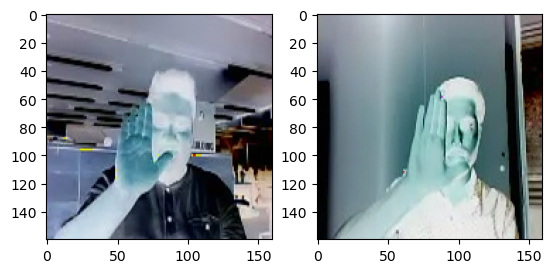

In [12]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=50,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])
axes[1].imshow(batch_data[3,15,:,:,:])

## Model 1
### Base Model - Batch Size = 40 and No. of Epochs = 15

In [13]:
class ModelConv3D1(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)                    │ (None, 20, 160, 160, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 20, 160, 160, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 20, 160, 160, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 10, 80, 80, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 10, 80, 80, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 10, 80, 80, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10, 80, 80, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 5, 40, 40, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_6 (Conv3D)                    │ (None, 5, 40, 40, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 5, 40, 40, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 5, 40, 40, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 2, 20, 20, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_7 (Conv3D)                    │ (None, 2, 20, 20, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 2, 20, 20, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 2, 20, 20, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_7 (MaxPooling3D)       │ (None, 1, 10, 10, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │         819,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,117,061 (4.26 MB)

 Trainable params: 1,116,325 (4.26 MB)

 Non-trainable params: 736 (2.88 KB)

In [15]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.3834 - loss: 1.6222
Epoch 1: val_loss improved from inf to 1.70439, saving model to model_init_2024-08-3100_45_43.664069/model-00001-1.40411-0.46305-1.70439-0.23000.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 161s 10s/step - categorical_accuracy: 0.3878 - loss: 1.6100 - val_categorical_accuracy: 0.2300 - val_loss: 1.7044 - learning_rate: 0.0010
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.6262 - loss: 0.8961
Epoch 2: val_loss improved from 1.70439 to 1.56331, saving model to model_init_2024-08-3100_45_43.664069/model-00002-0.88045-0.65309-1.56331-0.34000.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - categorical_accuracy: 0.6277 - loss: 0.8952 - val_categorical_accuracy: 0.3400 - val_loss: 1.5633 - learning_rate: 0.0010
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.7338 - loss: 0.6602
Epoch 3: val_loss did not improve from 1.56331
17/17 ━━━━━━

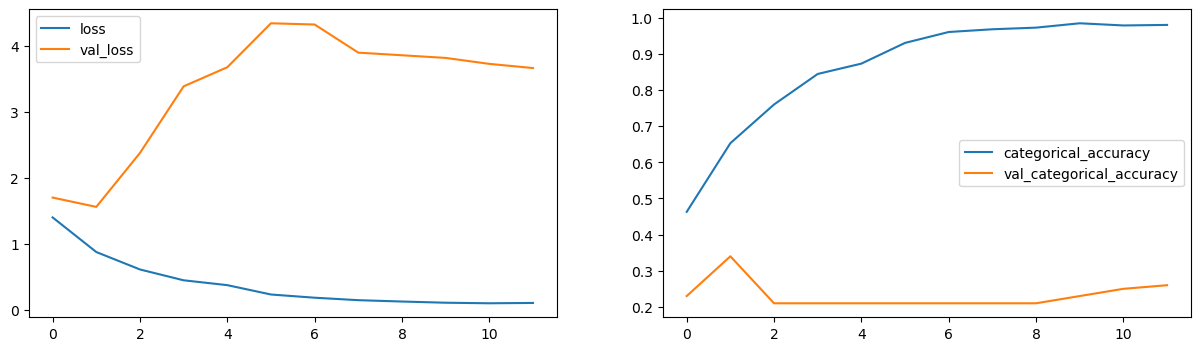

In [16]:
plot(history_model1)

### Summary
1. The training process shows that while the model is learning effectively from the training data (as evidenced by decreasing training loss and increasing training accuracy), it is not performing well on the validation set. 
2. The increasing validation loss and constant low validation accuracy indicate overfitting and poor generalization.

#### This model clearly shows sign of overfitting

## Model 2  
### Recude Batch Size = 20 and No. of Epochs = 25

In [17]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_8 (Conv3D)                    │ (None, 20, 160, 160, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 20, 160, 160, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 20, 160, 160, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_8 (MaxPooling3D)       │ (None, 10, 80, 80, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_9 (Conv3D)                    │ (None, 10, 80, 80, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 10, 80, 80, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 10, 80, 80, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_9 (MaxPooling3D)       │ (None, 5, 40, 40, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_10 (Conv3D)                   │ (None, 5, 40, 40, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 5, 40, 40, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 5, 40, 40, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_10 (MaxPooling3D)      │ (None, 2, 20, 20, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_11 (Conv3D)                   │ (None, 2, 20, 20, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 2, 20, 20, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 2, 20, 20, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_11 (MaxPooling3D)      │ (None, 1, 10, 10, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 3,638,981 (13.88 MB)

 Trainable params: 3,637,477 (13.88 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [18]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.4133 - loss: 1.8401
Epoch 1: val_loss improved from inf to 2.63726, saving model to model_init_2024-08-3101_06_18.626356/model-00001-1.73767-0.43741-2.63726-0.20000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 195s 6s/step - categorical_accuracy: 0.4140 - loss: 1.8372 - val_categorical_accuracy: 0.2000 - val_loss: 2.6373 - learning_rate: 0.0010
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.5324 - loss: 1.3284
Epoch 2: val_loss did not improve from 2.63726
34/34 ━━━━━━━━━━━━━━━━━━━━ 203s 6s/step - categorical_accuracy: 0.5325 - loss: 1.3283 - val_categorical_accuracy: 0.2400 - val_loss: 4.0640 - learning_rate: 0.0010
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.5666 - loss: 1.1735
Epoch 3: val_loss did not improve from 2.63726
34/34 ━━━━━━━━━━━━━━━━━━━━ 188s 6s/step - categorical_accuracy: 0.5671 - loss: 1.1728 - val_categorical_accuracy: 0.2400

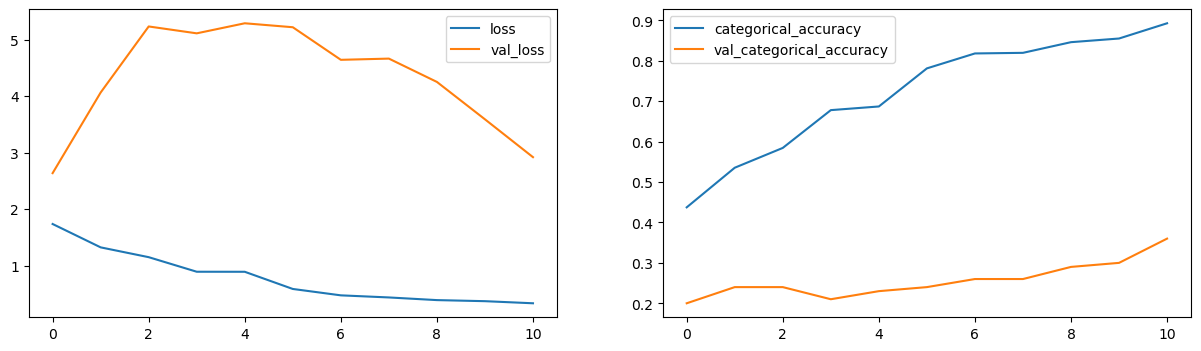

In [19]:
plot(history_model2)

### Summary:
#### Categorical Accuracy vs. Validation Categorical Accuracy:
1. Plot Description: The training accuracy curve should show a steady increase, while the validation accuracy curve likely remains relatively flat, indicating a lack of improvement in validation performance.
2. Interpretation: This plot visually represents the overfitting issue, where the model performs well on training data but fails to generalize to validation data.
#### Loss vs. Validation Loss:
1. Plot Description: The training loss curve will show a steady decrease, while the validation loss curve will initially drop but then rise significantly in later epochs.
2. Interpretation: The rising validation loss while training loss decreases is a classic indicator of overfitting, where the model is learning the training data's noise and specifics rather than general patterns.

#### The model is exhibiting some challenges with overfitting

## Model 3 -
### Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [20]:
class ModelConv3D3(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))


        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [21]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_12 (Conv3D)                   │ (None, 16, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 16, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 16, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_13 (Conv3D)                   │ (None, 16, 120, 120, 16)    │           6,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 16, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 16, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_12 (MaxPooling3D)      │ (None, 8, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_14 (Conv3D)                   │ (None, 8, 60, 60, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 8, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 8, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_15 (Conv3D)                   │ (None, 8, 60, 60, 32)       │          27,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 8, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 8, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_13 (MaxPooling3D)      │ (None, 4, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_16 (Conv3D)                   │ (None, 4, 30, 30, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 4, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 4, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_17 (Conv3D)                   │ (None, 4, 30, 30, 64)       │         110,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 4, 30, 30, 64)       │              

 Total params: 2,556,533 (9.75 MB)

 Trainable params: 2,554,549 (9.74 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [22]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.3465 - loss: 2.0734
Epoch 1: val_loss improved from inf to 3.63096, saving model to model_init_2024-08-3101_41_32.255499/model-00001-1.91956-0.38537-3.63096-0.29000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 195s 6s/step - categorical_accuracy: 0.3476 - loss: 2.0690 - val_categorical_accuracy: 0.2900 - val_loss: 3.6310 - learning_rate: 0.0010
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.5006 - loss: 1.4315
Epoch 2: val_loss did not improve from 3.63096
34/34 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - categorical_accuracy: 0.5007 - loss: 1.4309 - val_categorical_accuracy: 0.2100 - val_loss: 5.4833 - learning_rate: 0.0010
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.4930 - loss: 1.4005
Epoch 3: val_loss did not improve from 3.63096
34/34 ━━━━━━━━━━━━━━━━━━━━ 171s 5s/step - categorical_accuracy: 0.4942 - loss: 1.3975 - val_categorical_accuracy: 0.2100

34/34 ━━━━━━━━━━━━━━━━━━━━ 172s 5s/step - categorical_accuracy: 0.8828 - loss: 0.3559 - val_categorical_accuracy: 0.7900 - val_loss: 0.6886 - learning_rate: 4.0000e-05
Epoch 20/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.8646 - loss: 0.3442
Epoch 20: val_loss improved from 0.68862 to 0.52860, saving model to model_init_2024-08-3101_41_32.255499/model-00020-0.35385-0.86350-0.52860-0.84000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 174s 5s/step - categorical_accuracy: 0.8645 - loss: 0.3445 - val_categorical_accuracy: 0.8400 - val_loss: 0.5286 - learning_rate: 4.0000e-05
Epoch 21/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.8641 - loss: 0.3596
Epoch 21: val_loss did not improve from 0.52860
34/34 ━━━━━━━━━━━━━━━━━━━━ 197s 6s/step - categorical_accuracy: 0.8643 - loss: 0.3591 - val_categorical_accuracy: 0.8200 - val_loss: 0.5827 - learning_rate: 4.0000e-05
Epoch 22/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.8914 - loss: 0.3194
Epoc

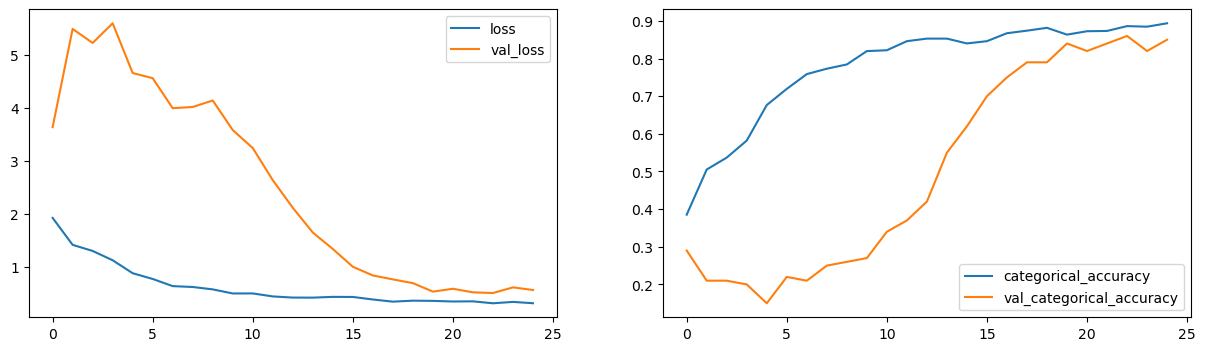

In [23]:
plot(history_model3)

### Conclusions:
1. This shows a steady improvement in validation metrics over the epochs. After initial fluctuations, the model achieves significant improvements in both validation loss and accuracy.

2. The learning rate was reduced multiple times, particularly in the latter epochs, which contributed to the refinement of model performance and stabilization of validation metrics.

3. The final validation accuracy of 85.00% shows that the model correctly predicted the class labels for 85% of the samples in the validation set. This high accuracy reflects the model's strong performance and effective learning.

4. The model has demonstrated excellent performance, achieving both a low validation loss and high validation accuracy by the end of training. This suggests that the model has effectively learned from the data and generalized well to the validation set.

## Model 4
### Adding dropout at convolution layers

In [24]:
class ModelConv3D4(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [25]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d4_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_20 (Conv3D)                   │ (None, 16, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 16, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 16, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_21 (Conv3D)                   │ (None, 16, 120, 120, 16)    │           6,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 16, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 16, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_16 (MaxPooling3D)      │ (None, 8, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 8, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_22 (Conv3D)                   │ (None, 8, 60, 60, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_22 (Activation)           │ (None, 8, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 8, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_23 (Conv3D)                   │ (None, 8, 60, 60, 32)       │          27,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_23 (Activation)           │ (None, 8, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 8, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_17 (MaxPooling3D)      │ (None, 4, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 4, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_24 (Conv3D)                   │ (None, 4, 30, 30, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_24 (Activation)           │ (None, 4, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 4, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 2,556,533 (9.75 MB)

 Trainable params: 2,554,549 (9.74 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [26]:
%%time
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.3596 - loss: 1.8974
Epoch 1: val_loss improved from inf to 3.05811, saving model to model_init_2024-08-3102_55_08.996833/model-00001-1.72461-0.40422-3.05811-0.21000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 177s 5s/step - categorical_accuracy: 0.3609 - loss: 1.8925 - val_categorical_accuracy: 0.2100 - val_loss: 3.0581 - learning_rate: 0.0010
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.5145 - loss: 1.2683
Epoch 2: val_loss did not improve from 3.05811
34/34 ━━━━━━━━━━━━━━━━━━━━ 178s 5s/step - categorical_accuracy: 0.5149 - loss: 1.2662 - val_categorical_accuracy: 0.2100 - val_loss: 5.7276 - learning_rate: 0.0010
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.5409 - loss: 1.1795
Epoch 3: val_loss did not improve from 3.05811
34/34 ━━━━━━━━━━━━━━━━━━━━ 163s 5s/step - categorical_accuracy: 0.5414 - loss: 1.1775 - val_categorical_accuracy: 0.2200

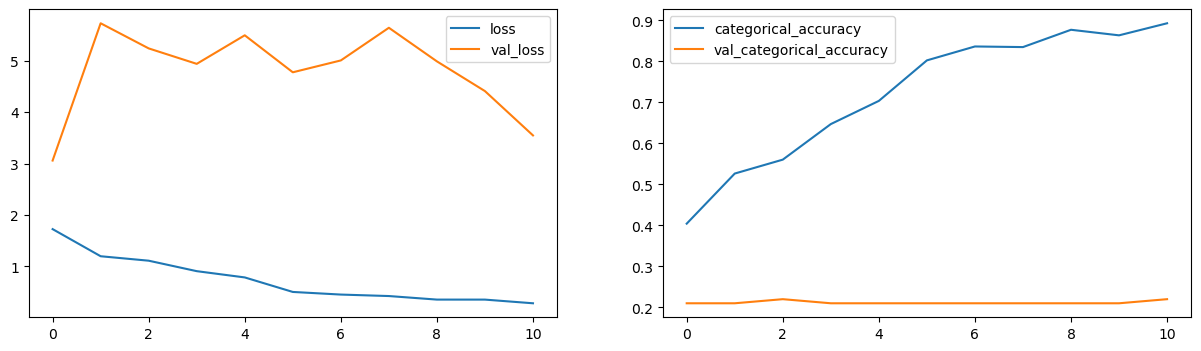

In [27]:
plot(history_model4)

#### The model is exhibiting some challenges with overfitting

## Model 5 - Reducing the number of parameters

In [28]:
class ModelConv3D5(ModelBuilder):

    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [29]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d5_model=conv_3d5.define_model(dense_neurons=64,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_28 (Conv3D)                   │ (None, 16, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_28 (Activation)           │ (None, 16, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 16, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_20 (MaxPooling3D)      │ (None, 8, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_29 (Conv3D)                   │ (None, 8, 60, 60, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_29 (Activation)           │ (None, 8, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 8, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_21 (MaxPooling3D)      │ (None, 4, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_30 (Conv3D)                   │ (None, 4, 30, 30, 64)       │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_30 (Activation)           │ (None, 4, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 4, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_22 (MaxPooling3D)      │ (None, 2, 15, 15, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_31 (Conv3D)                   │ (None, 2, 15, 15, 128)      │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_31 (Activation)           │ (None, 2, 15, 15, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 2, 15, 15, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_23 (MaxPooling3D)      │ (None, 1, 7, 7, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │         401,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 504,709 (1.93 MB)

 Trainable params: 503,973 (1.92 MB)

 Non-trainable params: 736 (2.88 KB)

In [30]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3126 - loss: 1.8516
Epoch 1: val_loss improved from inf to 1.88010, saving model to model_init_2024-08-3103_26_37.113161/model-00001-1.64402-0.38009-1.88010-0.16000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - categorical_accuracy: 0.3145 - loss: 1.8457 - val_categorical_accuracy: 0.1600 - val_loss: 1.8801 - learning_rate: 2.0000e-04
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5444 - loss: 1.1598
Epoch 2: val_loss did not improve from 1.88010
34/34 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - categorical_accuracy: 0.5447 - loss: 1.1588 - val_categorical_accuracy: 0.2100 - val_loss: 2.2770 - learning_rate: 2.0000e-04
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6284 - loss: 0.9618
Epoch 3: val_loss did not improve from 1.88010
34/34 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - categorical_accuracy: 0.6285 - loss: 0.9610 - val_categorical_accuracy:

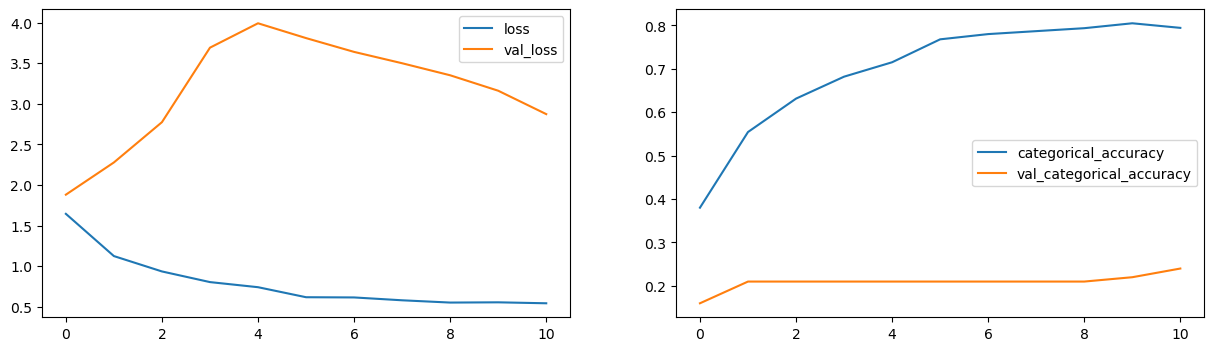

In [31]:
plot(history_model5)

### Conclusion
1. Overfitting: The primary concern is that the model is overfitting to the training data. While the training accuracy improves, the validation accuracy does not improve and even deteriorates over time. The validation loss also increases, further supporting this observation.

2. Model Performance: The model appears to be learning well on the training data but struggling with generalization, as indicated by the higher and increasing val_loss and stagnating val_categorical_accuracy.

#### No Improvement Reducing the number of parameters. Model Still Overfits.

## Model 6 - CNN- LSTM Model

In [32]:
class RNNCNN1(ModelBuilder):

    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [33]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 18, 120, 120, 16)    │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 18, 120, 120, 16)    │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 18, 60, 60, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 18, 60, 60, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 18, 60, 60, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 18, 30, 30, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 18, 30, 30, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 18, 30, 30, 64)      │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 18, 15, 15, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 18, 15, 15, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 18, 15, 15, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 18, 7, 7, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 18, 7, 7, 256)       │         295,168 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, 18, 7, 7, 256)       │           1,024 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ (None, 18, 3, 3, 256)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, 18, 2304)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │       1,245,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,657,445 (6.32 MB)

 Trainable params: 1,656,453 (6.32 MB)

 Non-trainable params: 992 (3.88 KB)

In [34]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model6=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.3828 - loss: 1.4426 
Epoch 1: val_loss improved from inf to 1.41542, saving model to model_init_2024-08-3103_45_52.769466/model-00001-1.29802-0.46531-1.41542-0.42000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 422s 12s/step - categorical_accuracy: 0.3852 - loss: 1.4385 - val_categorical_accuracy: 0.4200 - val_loss: 1.4154 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - categorical_accuracy: 0.6358 - loss: 0.9480 
Epoch 2: val_loss improved from 1.41542 to 1.00188, saving model to model_init_2024-08-3103_45_52.769466/model-00002-0.97070-0.62293-1.00188-0.63000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 345s 10s/step - categorical_accuracy: 0.6354 - loss: 0.9487 - val_categorical_accuracy: 0.6300 - val_loss: 1.0019 - learning_rate: 0.0010
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - categorical_accuracy: 0.6421 - loss: 0.9156 
Epoch 3: val_loss improved from 1.00188 to 0.84355,

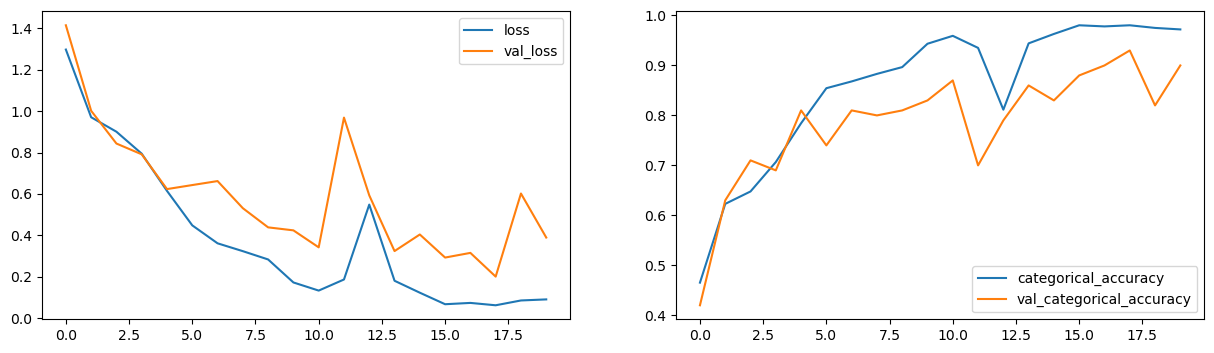

In [35]:
plot(history_model6)

#### Summary
1. The model demonstrated strong learning capabilities, reaching high accuracy and low loss values by the end of training.
2. Monitoring validation metrics closely helped in preventing overfitting and ensuring that the model can generalize well.
3. The overall performance suggests that the chosen architecture and training parameters were effective for the given task.

### Model 7 - CNN- LSTM Model [Batch Size = 5, no of Epochs = 25]

In [36]:
rnn_cnn1_2=RNNCNN1()
rnn_cnn1_2.initialize_path(project_folder)
rnn_cnn1_2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1_2.initialize_hyperparams(frames_to_sample=18,batch_size=5,num_epochs=25)
rnn_cnn1_2_model=rnn_cnn1_2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_2_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_16                  │ (None, 18, 120, 120, 16)    │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_17                  │ (None, 18, 120, 120, 16)    │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_18                  │ (None, 18, 60, 60, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_19                  │ (None, 18, 60, 60, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_20                  │ (None, 18, 60, 60, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_21                  │ (None, 18, 30, 30, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_22                  │ (None, 18, 30, 30, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_23                  │ (None, 18, 30, 30, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_24                  │ (None, 18, 15, 15, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_25                  │ (None, 18, 15, 15, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_26                  │ (None, 18, 15, 15, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_27                  │ (None, 18, 7, 7, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_28                  │ (None, 18, 7, 7, 256)       │         295,168 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_29                  │ (None, 18, 7, 7, 256)       │           1,024 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,657,445 (6.32 MB)

 Trainable params: 1,656,453 (6.32 MB)

 Non-trainable params: 992 (3.88 KB)

In [37]:
print("Total Params:", rnn_cnn1_2_model.count_params())
history_model6_1=rnn_cnn1_2.train_model(rnn_cnn1_2_model,augment_data=True)

Total Params: 1657445
Epoch 1/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3550 - loss: 1.4964
Epoch 1: val_loss improved from inf to 1.16820, saving model to model_init_2024-08-3105_41_37.649737/model-00001-1.37352-0.41176-1.16820-0.55000.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 377s 3s/step - categorical_accuracy: 0.3555 - loss: 1.4954 - val_categorical_accuracy: 0.5500 - val_loss: 1.1682 - learning_rate: 0.0010
Epoch 2/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5232 - loss: 1.1876
Epoch 2: val_loss improved from 1.16820 to 1.01423, saving model to model_init_2024-08-3105_41_37.649737/model-00002-1.17541-0.53469-1.01423-0.58000.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 357s 3s/step - categorical_accuracy: 0.5233 - loss: 1.1875 - val_categorical_accuracy: 0.5800 - val_loss: 1.0142 - learning_rate: 0.0010
Epoch 3/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5889 - loss: 1.0204
Epoch 3: val_loss did not improve from 1.01423
13

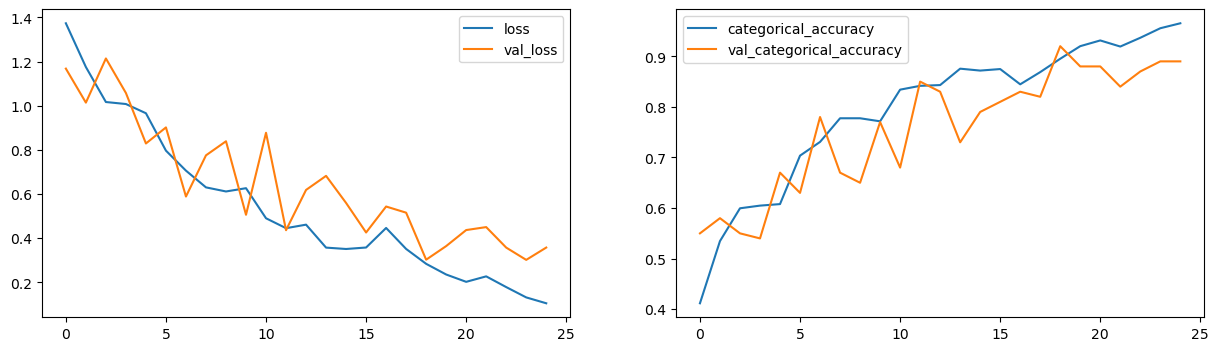

In [38]:
plot(history_model6_1)

#### Key Insights:
1. Model shows a significant improvement in accuracy over epochs, reaching a peak training accuracy of 96.21% in Epoch 24 and a peak validation accuracy of 92.00% in Epoch 19.

2. The model demonstrates a clear downward trend in training loss, reaching a low of 0.1322 in Epoch 24, while validation loss also improves, with the lowest validation loss being 0.3021 in Epoch 24.

3. While training accuracy consistently improves, validation accuracy and loss exhibit some fluctuations, indicating potential overfitting or variance in validation performance. The model's performance stabilizes with high accuracy and low loss towards the end of the training.

4. The learning rate was reduced towards the end of training in Epoch 23, likely in response to plateauing validation performance.

5. The model exhibits robust learning and adaptation over the training epochs, with significant improvements in both accuracy and loss metrics. The model is particularly strong towards the end of training, showcasing excellent performance with high accuracy and low loss, especially notable in Epochs 19-25.

## Let's apply some data augmentation & check the model performance.

In [39]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    # initialising the image properties
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
        
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs

    # MOST IMPORTANT PART HERE - The generator function
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size

            for batch in range(num_batches):
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels

            remaining_seq=len(t)%batch_size

            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels


    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):
        seq_len = remaining_seq if remaining_seq else batch_size

        batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))
        batch_labels = np.zeros((seq_len, self.num_classes))

        if augment:
            batch_data_aug = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))

        for folder in range(seq_len):
            imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
            for idx, item in enumerate(img_idx):
                # Performing image reading and resizing
                image = imread(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)

                # Convert to uint8 before resizing
                image = (image * 255).astype(np.uint8) if image.dtype == np.float32 else image.astype(np.uint8)
            
                # Resize the image using PIL
                image_resized = np.array(Image.fromarray(image).resize((self.image_width, self.image_height)))

                # Normalizing the images
                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255.0
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255.0
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255.0

                if augment:
                    # Random shifting and cropping for augmentation
                    shifted = cv2.warpAffine(
                        image,
                        np.float32([[1, 0, np.random.randint(-30, 30)], [0, 1, np.random.randint(-30, 30)]]),
                        (image.shape[1], image.shape[0])
                    )

                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)
                    cropped = shifted[x0:x1, y0:y1, :]

                    # Resize the cropped image using PIL
                    image_resized = np.array(Image.fromarray(cropped).resize((self.image_width, self.image_height)))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))

                    #shifted = cv2.warpAffine(image_resized,
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]),
                    #                        (image_resized.shape[1], image_resized.shape[0]))

                    batch_data_aug[folder, idx, :, :, 0] = (rotated[:, :, 0]) / 255.0
                    batch_data_aug[folder, idx, :, :, 1] = (rotated[:, :, 1]) / 255.0
                    batch_data_aug[folder, idx, :, :, 2] = (rotated[:, :, 2]) / 255.0

            batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

        if augment:
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])

        return batch_data, batch_labels



    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        # Update filepath format to include only available metrics
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
        # model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5


        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, initial_epoch=0)
        return history


    @abc.abstractmethod
    def define_model(self):
        pass

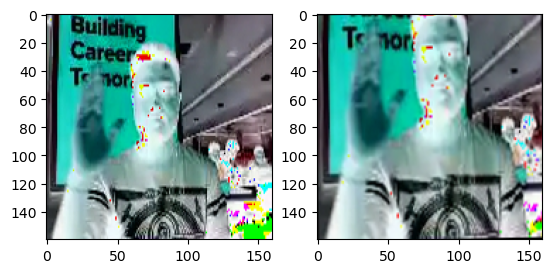

In [40]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])
axes[1].imshow(batch_data[3,29,:,:,:])

## Model 8 with Augmentation
### CNN - LSTM Model - Similar to Model 6

In [155]:
class RNNCNN1_Aug(ModelBuilderMoreAugmentation):

    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [156]:
rnn_cnn1_Aug=RNNCNN1_Aug()
rnn_cnn1_Aug.initialize_path(project_folder)
rnn_cnn1_Aug.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1_Aug.initialize_hyperparams(frames_to_sample=18,batch_size=10,num_epochs=25)
rnn_cnn1_Aug_model=rnn_cnn1_Aug.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_Aug_model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_127                 │ (None, 18, 120, 120, 16)    │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_128                 │ (None, 18, 120, 120, 16)    │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_129                 │ (None, 18, 60, 60, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_130                 │ (None, 18, 60, 60, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_131                 │ (None, 18, 60, 60, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_132                 │ (None, 18, 30, 30, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_133                 │ (None, 18, 30, 30, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_134                 │ (None, 18, 30, 30, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_135                 │ (None, 18, 15, 15, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_136                 │ (None, 18, 15, 15, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_137                 │ (None, 18, 15, 15, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_138                 │ (None, 18, 7, 7, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_139                 │ (None, 18, 7, 7, 256)       │         295,168 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_140                 │ (None, 18, 7, 7, 256)       │           1,024 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,657,445 (6.32 MB)

 Trainable params: 1,656,453 (6.32 MB)

 Non-trainable params: 992 (3.88 KB)

In [157]:
print("Total Params:", rnn_cnn1_Aug_model.count_params())
history_model6_Aug=rnn_cnn1_Aug.train_model(rnn_cnn1_Aug_model,augment_data=True)

Total Params: 1657445
Epoch 1/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.3876 - loss: 1.4278
Epoch 1: val_loss improved from inf to 0.99074, saving model to model_init_2024-09-0112_14_01.549281/model-00001-1.31974-0.43967-0.99074-0.60000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 488s 7s/step - categorical_accuracy: 0.3883 - loss: 1.4262 - val_categorical_accuracy: 0.6000 - val_loss: 0.9907 - learning_rate: 0.0010
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.6364 - loss: 0.9488
Epoch 2: val_loss improved from 0.99074 to 0.95796, saving model to model_init_2024-09-0112_14_01.549281/model-00002-1.01367-0.59351-0.95796-0.62000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 412s 6s/step - categorical_accuracy: 0.6358 - loss: 0.9497 - val_categorical_accuracy: 0.6200 - val_loss: 0.9580 - learning_rate: 0.0010
Epoch 3/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.6543 - loss: 0.8722
Epoch 3: val_loss improved from 0.95796 to 0.81523, saving 

Epoch 20/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.9478 - loss: 0.1699
Epoch 20: val_loss improved from 0.25536 to 0.24859, saving model to model_init_2024-09-0112_14_01.549281/model-00020-0.13650-0.95928-0.24859-0.88000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 444s 7s/step - categorical_accuracy: 0.9480 - loss: 0.1694 - val_categorical_accuracy: 0.8800 - val_loss: 0.2486 - learning_rate: 0.0010
Epoch 21/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.9722 - loss: 0.0898
Epoch 21: val_loss did not improve from 0.24859
67/67 ━━━━━━━━━━━━━━━━━━━━ 419s 6s/step - categorical_accuracy: 0.9721 - loss: 0.0899 - val_categorical_accuracy: 0.9000 - val_loss: 0.3057 - learning_rate: 0.0010
Epoch 22/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.9750 - loss: 0.0685
Epoch 22: val_loss did not improve from 0.24859
67/67 ━━━━━━━━━━━━━━━━━━━━ 422s 6s/step - categorical_accuracy: 0.9750 - loss: 0.0687 - val_categorical_accuracy: 0.8600 - val_loss:

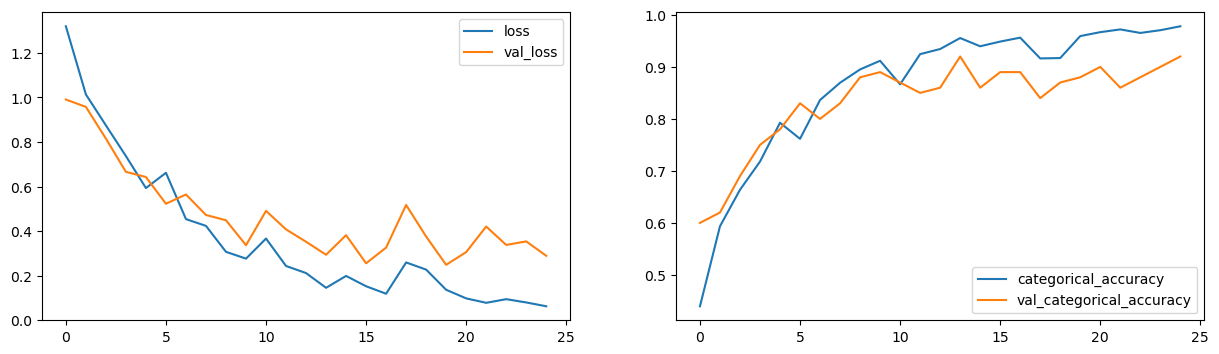

In [158]:
plot(history_model6_Aug)

## Summary :
1. The model consistently improves in both training and validation metrics throughout the epochs. This indicates effective learning and generalization.
2. The validation accuracy reaches a high value of ~92.00% by the end of training, and the validation loss stabilizes, suggesting that the model performs well on new, unseen data.
3. While the training metrics are very high, it’s crucial to ensure that the model doesn’t overfit to the training data. The validation metrics being high as well indicates good generalization.

### Model 9 CNN LSTM with GRU 

In [41]:
class RNNCNN2(ModelBuilderMoreAugmentation):

    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [42]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_32                  │ (None, 18, 120, 120, 16)    │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_33                  │ (None, 18, 120, 120, 16)    │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_34                  │ (None, 18, 60, 60, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_35                  │ (None, 18, 60, 60, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_36                  │ (None, 18, 60, 60, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_37                  │ (None, 18, 30, 30, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_38                  │ (None, 18, 30, 30, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_39                  │ (None, 18, 30, 30, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_40                  │ (None, 18, 15, 15, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_41                  │ (None, 18, 15, 15, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_42                  │ (None, 18, 15, 15, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_43                  │ (None, 18, 7, 7, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_44                  │ (None, 18, 6272)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 128)                 │       2,458,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128)                 │              

 Total params: 2,573,925 (9.82 MB)

 Trainable params: 2,573,445 (9.82 MB)

 Non-trainable params: 480 (1.88 KB)

In [43]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model7=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - categorical_accuracy: 0.3599 - loss: 1.5496 
Epoch 1: val_loss improved from inf to 0.93957, saving model to model_init_2024-08-3108_13_31.943780/model-00001-1.33833-0.44344-0.93957-0.64000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 442s 12s/step - categorical_accuracy: 0.3623 - loss: 1.5435 - val_categorical_accuracy: 0.6400 - val_loss: 0.9396 - learning_rate: 2.0000e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - categorical_accuracy: 0.6447 - loss: 0.9043 
Epoch 2: val_loss improved from 0.93957 to 0.81338, saving model to model_init_2024-08-3108_13_31.943780/model-00002-0.86835-0.66591-0.81338-0.71000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 421s 12s/step - categorical_accuracy: 0.6453 - loss: 0.9033 - val_categorical_accuracy: 0.7100 - val_loss: 0.8134 - learning_rate: 2.0000e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - categorical_accuracy: 0.7646 - loss: 0.6758 
Epoch 3: val_loss improved from 0.81338 to 

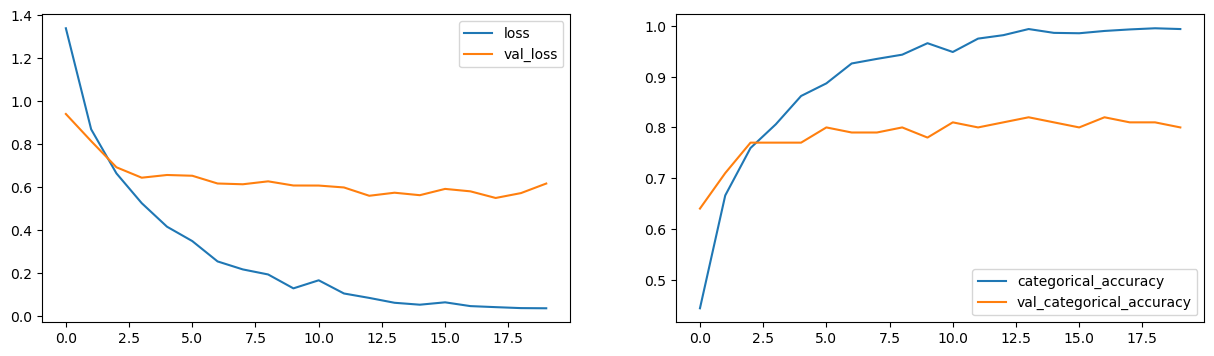

In [44]:
plot(history_model7)

### Summary
1. The model can achieve high accuracy on the training set, but overfitting is evident as the gap between training and validation metrics increases.
2. Early improvements in validation metrics show that the model generalizes well to unseen data up to a certain point.

## Model 9_1 CNN LSTM with GRU (batch_size=15,num_epochs=25)

In [69]:
rnn_cnn2_tune=RNNCNN2()
rnn_cnn2_tune.initialize_path(project_folder)
rnn_cnn2_tune.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2_tune.initialize_hyperparams(frames_to_sample=18,batch_size=15,num_epochs=25)
rnn_cnn2_tune_model=rnn_cnn2_tune.define_model(lstm_cells=128,dense_neurons=128,dropout=0.5)
rnn_cnn2_tune_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_69                  │ (None, 18, 120, 120, 16)    │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_70                  │ (None, 18, 120, 120, 16)    │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_71                  │ (None, 18, 60, 60, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_72                  │ (None, 18, 60, 60, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_73                  │ (None, 18, 60, 60, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_74                  │ (None, 18, 30, 30, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_75                  │ (None, 18, 30, 30, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_76                  │ (None, 18, 30, 30, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_77                  │ (None, 18, 15, 15, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_78                  │ (None, 18, 15, 15, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_79                  │ (None, 18, 15, 15, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_80                  │ (None, 18, 7, 7, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_81                  │ (None, 18, 6272)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 128)                 │       2,458,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 128)                 │              

 Total params: 2,573,925 (9.82 MB)

 Trainable params: 2,573,445 (9.82 MB)

 Non-trainable params: 480 (1.88 KB)

In [70]:
print("Total Params:", rnn_cnn2_tune_model.count_params())
history_model7_tune=rnn_cnn2_tune.train_model(rnn_cnn2_tune_model,augment_data=True)

Total Params: 2573925
Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.2428 - loss: 1.9524
Epoch 1: val_loss improved from inf to 1.07717, saving model to model_init_2024-08-3115_35_13.338210/model-00001-1.71424-0.30995-1.07717-0.63000.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 381s 8s/step - categorical_accuracy: 0.2443 - loss: 1.9473 - val_categorical_accuracy: 0.6300 - val_loss: 1.0772 - learning_rate: 2.0000e-04
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.4709 - loss: 1.3151
Epoch 2: val_loss improved from 1.07717 to 0.93701, saving model to model_init_2024-08-3115_35_13.338210/model-00002-1.25859-0.49472-0.93701-0.63000.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 357s 8s/step - categorical_accuracy: 0.4714 - loss: 1.3139 - val_categorical_accuracy: 0.6300 - val_loss: 0.9370 - learning_rate: 2.0000e-04
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.5383 - loss: 1.1381
Epoch 3: val_loss improved from 0.93701 to 0.80292,

Epoch 19/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.9232 - loss: 0.2105
Epoch 19: val_loss did not improve from 0.45809
45/45 ━━━━━━━━━━━━━━━━━━━━ 349s 8s/step - categorical_accuracy: 0.9234 - loss: 0.2100 - val_categorical_accuracy: 0.8400 - val_loss: 0.5526 - learning_rate: 2.0000e-04
Epoch 20/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.9367 - loss: 0.1784
Epoch 20: val_loss did not improve from 0.45809
45/45 ━━━━━━━━━━━━━━━━━━━━ 358s 8s/step - categorical_accuracy: 0.9367 - loss: 0.1788 - val_categorical_accuracy: 0.8300 - val_loss: 0.5567 - learning_rate: 2.0000e-04
Epoch 21/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.9488 - loss: 0.1613
Epoch 21: val_loss did not improve from 0.45809

Epoch 21: ReduceLROnPlateau reducing learning rate to 3.9999998989515007e-05.
45/45 ━━━━━━━━━━━━━━━━━━━━ 351s 8s/step - categorical_accuracy: 0.9487 - loss: 0.1614 - val_categorical_accuracy: 0.8700 - val_loss: 0.4749 - learning_ra

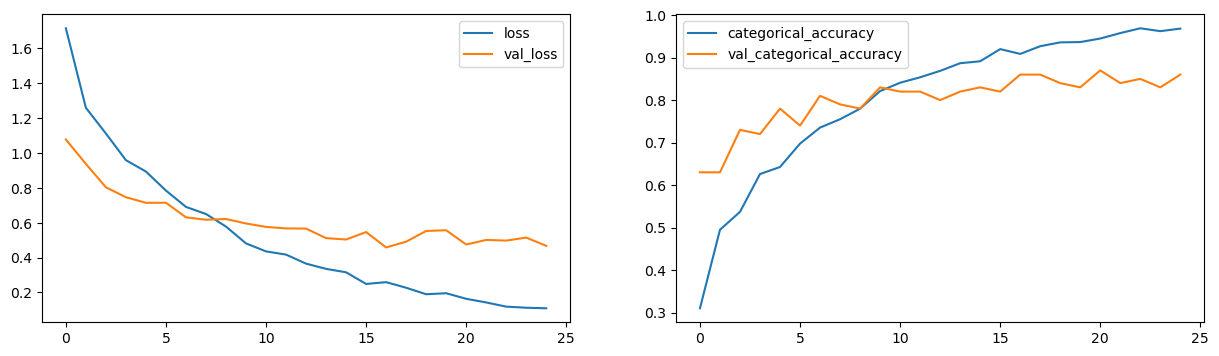

In [71]:
plot(history_model7_tune)

### Summary :
1. The training accuracy improves significantly and consistently, reaching very high values (97.09%).
2. Validation accuracy improves initially but then stabilizes around 86.00%, with fluctuations toward the end.
3. Training loss continues to decrease, while validation loss shows a more erratic behavior, with some improvements but also some periods of stagnation.
4. The validation loss shows significant improvements early on but then plateaus and even slightly worsens toward the end of training.
5. The model performs exceedingly well on training data but does not generalize as effectively to unseen data.

## Model 10 CNN LSTM with Bidirectional GRU + Regularization

In [72]:
from tensorflow.keras.layers import Bidirectional, GRU
from tensorflow.keras import regularizers

class RNNCNN2_Opt(ModelBuilderMoreAugmentation):

    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(Bidirectional(GRU(lstm_cells)))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu',  kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [73]:
rnn_cnn2_opt=RNNCNN2_Opt()
rnn_cnn2_opt.initialize_path(project_folder)
rnn_cnn2_opt.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2_opt.initialize_hyperparams(frames_to_sample=18,batch_size=15,num_epochs=25)
rnn_cnn2_opt_model=rnn_cnn2_opt.define_model(lstm_cells=128,dense_neurons=128,dropout=0.5)
rnn_cnn2_opt_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_82                  │ (None, 18, 120, 120, 16)    │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_83                  │ (None, 18, 120, 120, 16)    │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_84                  │ (None, 18, 60, 60, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_85                  │ (None, 18, 60, 60, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_86                  │ (None, 18, 60, 60, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_87                  │ (None, 18, 30, 30, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_88                  │ (None, 18, 30, 30, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_89                  │ (None, 18, 30, 30, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_90                  │ (None, 18, 15, 15, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_91                  │ (None, 18, 15, 15, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_92                  │ (None, 18, 15, 15, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_93                  │ (None, 18, 7, 7, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_94                  │ (None, 18, 6272)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │       4,916,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 256)                 │              

 Total params: 5,048,677 (19.26 MB)

 Trainable params: 5,048,197 (19.26 MB)

 Non-trainable params: 480 (1.88 KB)

In [74]:
print("Total Params:", rnn_cnn2_opt_model.count_params())
history_model7_opt=rnn_cnn2_opt.train_model(rnn_cnn2_opt_model,augment_data=True)

Total Params: 5048677
Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.2489 - loss: 3.7492
Epoch 1: val_loss improved from inf to 2.83369, saving model to model_init_2024-08-3118_01_01.407824/model-00001-3.47121-0.29713-2.83369-0.53000.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 381s 8s/step - categorical_accuracy: 0.2499 - loss: 3.7431 - val_categorical_accuracy: 0.5300 - val_loss: 2.8337 - learning_rate: 2.0000e-04
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.4588 - loss: 3.0099
Epoch 2: val_loss improved from 2.83369 to 2.53284, saving model to model_init_2024-08-3118_01_01.407824/model-00002-2.89876-0.48416-2.53284-0.63000.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 354s 8s/step - categorical_accuracy: 0.4594 - loss: 3.0075 - val_categorical_accuracy: 0.6300 - val_loss: 2.5328 - learning_rate: 2.0000e-04
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.5818 - loss: 2.6306
Epoch 3: val_loss improved from 2.53284 to 2.36595,

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.9728 - loss: 1.1276
Epoch 18: val_loss did not improve from 1.31284
45/45 ━━━━━━━━━━━━━━━━━━━━ 348s 8s/step - categorical_accuracy: 0.9728 - loss: 1.1275 - val_categorical_accuracy: 0.8900 - val_loss: 1.3240 - learning_rate: 2.0000e-04
Epoch 19/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.9807 - loss: 1.0884
Epoch 19: val_loss improved from 1.31284 to 1.29949, saving model to model_init_2024-08-3118_01_01.407824/model-00019-1.07759-0.97738-1.29949-0.90000.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 351s 8s/step - categorical_accuracy: 0.9806 - loss: 1.0881 - val_categorical_accuracy: 0.9000 - val_loss: 1.2995 - learning_rate: 2.0000e-04
Epoch 20/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.9816 - loss: 1.0299
Epoch 20: val_loss improved from 1.29949 to 1.27169, saving model to model_init_2024-08-3118_01_01.407824/model-00020-1.01553-0.98190-1.27169-0.90000.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 3

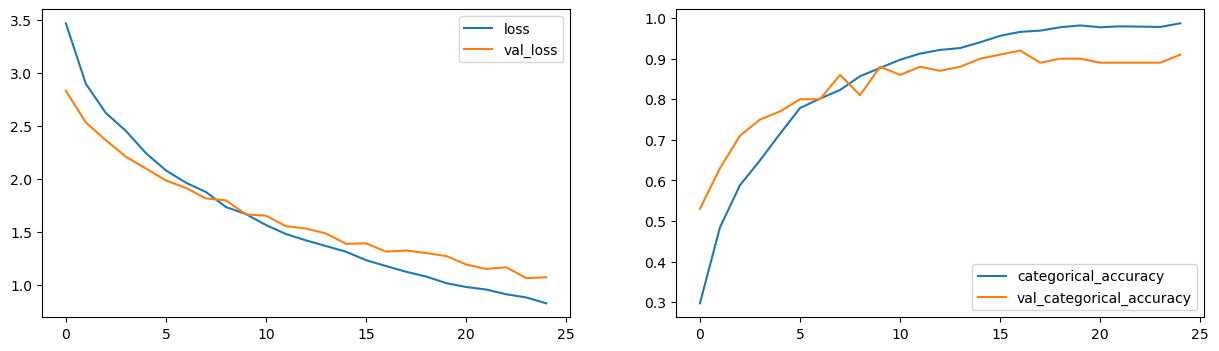

In [75]:
plot(history_model7_opt)

### Summary:
1. The model exhibits signs of potential overfitting. While the training metrics continue to improve, the validation performance has not consistently improved in the last few epochs, and there are fluctuations in the validation loss.

### Model 11 - CNN with GRU  (with trainable weights of Transfer Learning)

In [111]:
# model class to process the model building logic
from tensorflow.keras.applications import MobileNet

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        mobilenet_transfer = MobileNet(weights='imagenet', include_top=False, input_shape=(self.image_height, self.image_width, self.channels))
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells, return_sequences=False))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [112]:
# Process the model class logic
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_99                  │ (None, 16, 3, 3, 1024)      │       3,228,864 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_100                 │ (None, 16, 3, 3, 1024)      │           4,096 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_101                 │ (None, 16, 1, 1, 1024)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_102                 │ (None, 16, 1024)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 128)                 │         443,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,693,253 (14.09 MB)

 Trainable params: 3,669,317 (14.00 MB)

 Non-trainable params: 23,936 (93.50 KB)

In [113]:
# Execute the model
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model8=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4059 - loss: 1.4289
Epoch 1: val_loss improved from inf to 0.36010, saving model to model_init_2024-09-0100_00_24.994737/model-00001-1.12298-0.55279-0.36010-0.82000.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - categorical_accuracy: 0.4070 - loss: 1.4266 - val_categorical_accuracy: 0.8200 - val_loss: 0.3601 - learning_rate: 0.0010
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7456 - loss: 0.7160
Epoch 2: val_loss improved from 0.36010 to 0.23810, saving model to model_init_2024-09-0100_00_24.994737/model-00002-0.67566-0.76697-0.23810-0.93000.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - categorical_accuracy: 0.7457 - loss: 0.7157 - val_categorical_accuracy: 0.9300 - val_loss: 0.2381 - learning_rate: 0.0010
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8505 - loss: 0.4784
Epoch 3: val_loss improved from 0.23810 to 0.1904

Epoch 20/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9932 - loss: 0.0181
Epoch 20: val_loss did not improve from 0.00588

Epoch 20: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
133/133 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - categorical_accuracy: 0.9932 - loss: 0.0181 - val_categorical_accuracy: 0.9900 - val_loss: 0.0303 - learning_rate: 2.0000e-04


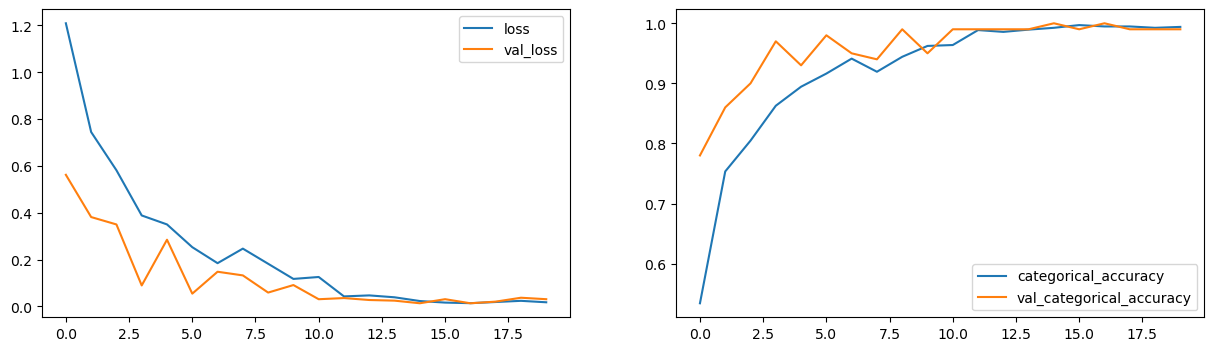

In [48]:
# Plot the model output
plot(history_model8)

### Observations:
1. **Overfitting Management:** The validation accuracy remained high and close to the training accuracy, which indicates minimal overfitting. This is a positive sign, showing that the model has a good capacity to generalize.
2. **Effective Learning Rate Adjustment:** The use of ReduceLROnPlateau helped in managing the learning rate dynamically. When the validation loss did not improve for a few epochs, the learning rate was reduced, helping the model to fine-tune and converge better.
3. **Overall Model Performance:** Achieving 100% validation accuracy in multiple epochs, with a significantly reduced validation loss, shows that the model is highly effective for the given task.

#### The model trained effectively, as seen by the progressive improvement in both training and validation accuracy, alongside decreasing loss values. The model reached high accuracy rates with low validation loss, indicating good performance and generalization ability. Adjustments to the learning rate proved beneficial in fine-tuning the model's learning process, allowing it to converge effectively without overfitting. The results suggest that the model is well-suited for its classification task, maintaining robust performance on unseen data.

# Loading model and Testing

In [159]:
# Model-8 (Final)
import time
from keras.models import load_model

final_model_aug = load_model('model_init_2024-09-0112_14_01.549281/model-00020-0.13650-0.95928-0.24859-0.88000.keras')
# Inspect the model architecture
print(final_model_aug.summary())

test_generator=RNNCNN1_Aug()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=10,num_epochs=25)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_127                 │ (None, 18, 120, 120, 16)    │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_128                 │ (None, 18, 120, 120, 16)    │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_129                 │ (None, 18, 60, 60, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_130                 │ (None, 18, 60, 60, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_131                 │ (None, 18, 60, 60, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_132                 │ (None, 18, 30, 30, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_133                 │ (None, 18, 30, 30, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_134                 │ (None, 18, 30, 30, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_135                 │ (None, 18, 15, 15, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_136                 │ (None, 18, 15, 15, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_137                 │ (None, 18, 15, 15, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_138                 │ (None, 18, 7, 7, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_139                 │ (None, 18, 7, 7, 256)       │         295,168 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_140                 │ (None, 18, 7, 7, 256)       │           1,024 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,970,353 (18.96 MB)

 Trainable params: 1,656,453 (6.32 MB)

 Non-trainable params: 992 (3.88 KB)

 Optimizer params: 3,312,908 (12.64 MB)

None


In [160]:
print(batch_labels)
print(np.argmax(final_model_aug.predict(batch_data[:,:,:,:,:]),axis=1))

[[0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[4 1 3 4 1 0 2 3 0 0]


In [125]:
# # Model-10 (Final)
# import time
# from keras.models import load_model

# model = load_model('model_init_2024-09-0100_00_24.994737/model-00013-0.05054-0.98492-0.01658-1.00000.keras')


# # Inspect the model architecture
# print(model.summary(expand_nested=True))

# test_generator=RNNCNN_TL2()
# test_generator.initialize_path(project_folder)
# test_generator.initialize_image_properties(image_height=120,image_width=120)
# test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
# g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
# batch_data, batch_labels=next(g)

# print(batch_labels)
# print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))


ValueError: Exception encountered when calling TimeDistributed.call().

[1mCannot convert '16' to a shape.[0m

Arguments received by TimeDistributed.call():
  • args=('<KerasTensor shape=(None, 16, 120, 120, 3), dtype=float32, sparse=False, name=input_layer_19>',)
  • kwargs={'mask': 'None'}